In [4]:
"""
Forward needs to be setup to do individual subdomain evaluations

Inner needs to iterate through the indices and provide the indexes to forward. 
It also does the window multiplication.

we vmap the inner function over the x_batch, the subdomains J and the basis function C

Where does the final output layer go?
Does this match the ELM-FBPINN architecture?


Is there a simpler version of the domain decomposition that I can make for now that doesn't do the indexing?

I would need to defined the subdomains, for each input, 
I would need to do a condition check on whether it is  in the subdomain, 
if it is, do forward pass, if not, do nothing.

I would need to do a vmap over the subdomains, and then a vmap over the inputs.

This would mean that the same basis functions are used in each subdomain for all calculations, and would mean changing things less overall.
"""




"\nForward needs to be setup to do individual subdomain evaluations\n\nInner needs to iterate through the indices and provide the indexes to forward. \nIt also does the window multiplication.\n\nwe vmap the inner function over the x_batch, the subdomains J and the basis function C\n\nWhere does the final output layer go?\nDoes this match the ELM-FBPINN architecture?\n\n\nIs there a simpler version of the domain decomposition that I can make for now that doesn't do the indexing?\n\nI would need to defined the subdomains, for each input, \nI would need to do a condition check on whether it is  in the subdomain, \nif it is, do forward pass, if not, do nothing.\n\nI would need to do a vmap over the subdomains, and then a vmap over the inputs.\n\nThis would mean that the same basis functions are used in each subdomain for all calculations, and would mean changing things less overall.\n"

In [9]:
import sys
sys.path.append('../')
import jax.numpy as jnp
import jax
import jax.numpy as jnp
from jax import random
import optax
from functools import partial
import matplotlib.pyplot as plt
from windows import initInterval, cosine, norm, unnorm
from matrix_builder import generate_indices
from matrix_builder import elmfbpinn

In [10]:
# Damped Harmonic Oscillator parameters
m = 1
delta = 2
mu = 2 * delta
omega_0 = 80
k = omega_0**2
omega = jnp.sqrt(omega_0**2 - delta**2)


# Damped harmonic oscillator solution and its derivatives
def harm_u_exact(t):
    phi = jnp.arctan(-delta / omega)
    A = 1 / (2 * jnp.cos(phi))
    return 2 * A * jnp.exp(-delta * t) * jnp.cos(phi + omega_0 * t)


def zero_RHS(t):
    return 0.0 * harm_u_exact(t)

In [11]:
#generate subdomains and indices


xmin, xmax = 0,1
J = 3
C= 3
n_point = 5

x_train = jnp.linspace(xmin, xmax, n_point)
y_train = harm_u_exact(x_train)

xmins, xmaxs = initInterval(J,xmin, xmax)

# Assign points to subdomains
row_indices, col_indices = generate_indices(J, C, xmins, xmaxs, x_train.flatten())



In [18]:
import jax
import jax.numpy as jnp
from jax import random
import optax
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(42)

# Define the exact solution for the damped harmonic oscillator
m = 1
delta = 2
mu = 2 * delta
omega_0 = 80
k = omega_0**2
omega = jnp.sqrt(omega_0**2 - delta**2)

def harm_u_exact(t):
    phi = jnp.arctan(-delta / omega)
    A = 1 / (2 * jnp.cos(phi))
    return 2 * A * jnp.exp(-delta * t) * jnp.cos(phi + omega * t)


# initialise weights and biases
def init_params(layers, key): 
    params = []
    keys = random.split(key, len(layers) - 1)
    for in_size, out_size, k in zip(layers[:-1], layers[1:], keys):
        weight = random.normal(k, (in_size, out_size)) * jnp.sqrt(1 / in_size)
        bias = jnp.zeros(out_size)
        params.append((weight, bias))
    return params

#def inner(params,xmins,xmaxs, j, x): #for each x point
    # xmin, xmax = xmins[j], xmaxs[j]
    # condition on x
    
    # window function x
    # evaluate forward on x
    
    # return window * evaluation
    

def forward(x,params):
    for weight, bias in params[:-1]:
        x = jnp.tanh(jnp.dot(x, weight) + bias)
    final_weight, final_bias = params[-1]
    return jnp.dot(x, final_weight) + final_bias

# loss function
def loss_fn(params, x, y):
    preds = jax.vmap(forward, in_axes=(0, None))(x, params)
    return jnp.mean((preds - y)**2)

# training step
@partial(jax.jit, static_argnums=(4,))
def train_step(params, opt_state, x, y, optimizer):
    loss, grads = jax.value_and_grad(loss_fn)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Define the neural network architecture
layer_sizes = [1, 32,32, 1] 
learning_rate = 1e-2
epochs = 50000
#J=3
xmin, xmax = 0,1

# Initialize model and optimizer
key, subkey = random.split(key)
params = init_params(layer_sizes, subkey)
#xmins, xmaxs = initInterval(J,xmin,xmax)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

x_train = jnp.linspace(0, 1, 300).reshape(-1, 1)
y_train = harm_u_exact(x_train) 


In [19]:
# Training loop
loss_values = []
for epoch in range(epochs):
    params, opt_state, loss = train_step(params, opt_state, x_train, y_train, optimizer)
    loss_values.append(loss)
    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")

Epoch 0, Loss: 0.460401
Epoch 10000, Loss: 0.009478
Epoch 20000, Loss: 0.005403
Epoch 30000, Loss: 0.004733
Epoch 40000, Loss: 0.005999


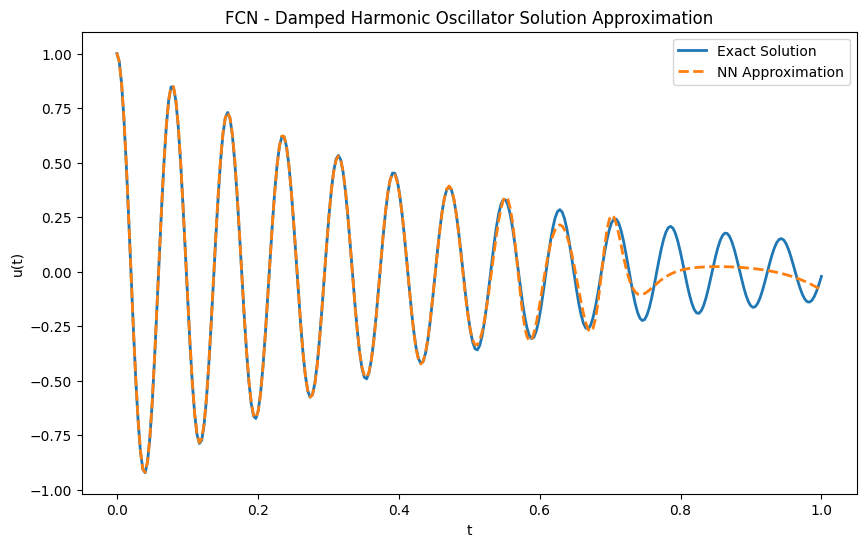

In [20]:
# Evaluate the model
fcn_u_pred = jax.vmap(forward,in_axes=(0, None))(x_train,params).flatten()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, label="Exact Solution", linewidth=2)
plt.plot(x_train, fcn_u_pred, label="NN Approximation", linestyle="--", linewidth=2)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("FCN - Damped Harmonic Oscillator Solution Approximation")
plt.legend()
plt.show()

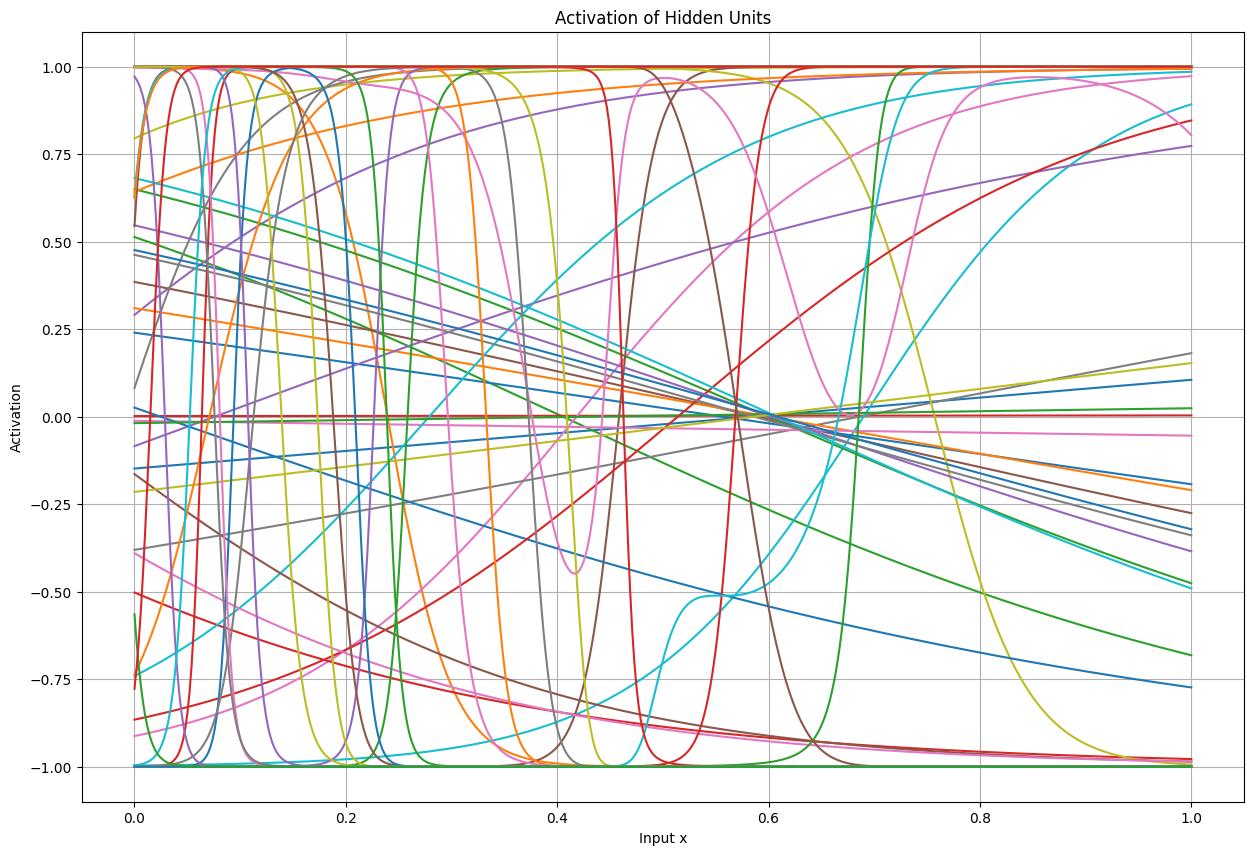

In [21]:
import numpy as np

# Function to evaluate activations of the hidden units
def get_hidden_activations(x, params,sigma):
    activations = []
    for weight, bias in params[:-1]:  # Iterate over all hidden layers
        x = sigma(jnp.dot(x, weight) + bias)
        activations.append(x)
    return activations

# Generate a set of x values to evaluate the activations
x_vals = jnp.linspace(0, 1, 500).reshape(-1, 1)

# Get the activations for the hidden units
hidden_activations = get_hidden_activations(x_vals, params,jnp.tanh)

# Plot the activations for each hidden unit
plt.figure(figsize=(15, 10))
for i, activation in enumerate(hidden_activations):
    plt.plot(x_vals, activation, label=f'Hidden Unit {i+1}')
    
plt.xlabel('Input x')
plt.ylabel('Activation')
plt.title('Activation of Hidden Units')
plt.grid()
plt.show()

In [26]:
key = random.PRNGKey(42)

# Define the exact solution for the damped harmonic oscillator
m = 1
delta = 2
mu = 2 * delta
omega_0 = 80
k = omega_0**2
omega = jnp.sqrt(omega_0**2 - delta**2)

def harm_u_exact(t):
    phi = jnp.arctan(-delta / omega)
    A = 1 / (2 * jnp.cos(phi))
    return 2 * A * jnp.exp(-delta * t) * jnp.cos(phi + omega * t)

# Initialize weights and biases
def init_params(layers, key): 
    params = []
    keys = random.split(key, len(layers) - 1)
    for in_size, out_size, k in zip(layers[:-1], layers[1:], keys):
        weight = random.normal(k, (in_size, out_size)) * jnp.sqrt(2 / in_size)
        bias = jnp.zeros(out_size)
        params.append((weight, bias))
    return params

# Normalization and denormalization functions
def norm(mu, sd, x):
    return (x - mu) / sd

def unnorm(mu, sd, x):
    return x * sd + mu

# Forward pass through the neural network
def forward(x, params):
    for weight, bias in params[:-1]:
        x = jnp.sin(jnp.dot(x, weight) + bias)
        
    final_weight, final_bias = params[-1]
    return jnp.dot(x, final_weight) + final_bias

# Function to be vmapped across the x points and subdomains
def inner(params, j, J, xmins, xmaxs, x):
    xmin, xmax = xmins[j], xmaxs[j]
    mu = (xmin + xmax) / 2
    sd = (xmax - xmin) / 2

    w = cosine(xmin, xmax, x) #Window(POU) function
    x = norm(mu, sd, x)
    x = forward(x, params)
    x = unnorm(0, 1, x)

    return w * x

def cosine(xmin, xmax, x):
    mu, sd = (xmin+xmax)/2, (xmax-xmin)/2
    ws = ((1+jnp.cos(jnp.pi*(x-mu)/sd))/2)**2
    ws = jnp.heaviside(x-xmin,1)*jnp.heaviside(xmax-x,1)*ws
    w = jnp.prod(ws, axis=0, keepdims=True)
    return w

# Partition of Unity window function
def window_hat(x, xmin, xmax):
    condition = jnp.logical_and(x >= xmin, x <= xmax)
    mu = (xmin + xmax) / 2.0
    sd = (xmax - xmin) / 2.0
    return jnp.where(condition, (1 + jnp.cos(jnp.pi * (x - mu) / sd)) ** 2, 0)

def POU(x, j, xmins, xmaxs, J):
    w_k = jnp.array([window_hat(x, xmins[k], xmaxs[k]) for k in range(J)])
    w_j = window_hat(x, xmins[j], xmaxs[j])
    return w_j / jnp.sum(w_k)

#Loss Function
def loss_fn(params, x, y, J, xmins, xmaxs):
    
    contributions = jax.vmap(
        jax.vmap(inner, in_axes=(None, 0, None, None, None,None)),
        in_axes=(None, None, None, None, None, 0)
    )(params, jnp.arange(J), J, xmins, xmaxs, x)
    
    preds = jnp.sum(contributions, axis=1)
    
    return jnp.mean((preds - y) ** 2)

# Training step
@partial(jax.jit, static_argnums=(4,5))
def train_step(params, opt_state, x, y, optimizer, J, xmins, xmaxs):
    loss, grads = jax.value_and_grad(loss_fn)(params, x, y, J, xmins, xmaxs)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Define parameters
layer_sizes = [1, 32, 1] 
learning_rate = 1e-2
epochs = 50000
J = 20
xmin, xmax = 0, 1
DDNN_params = init_params(layer_sizes, key)
xmins, xmaxs = initInterval(J, xmin, xmax)
x_train = jnp.linspace(xmin, xmax, 300).reshape(-1, 1)
y_train = harm_u_exact(x_train)

# Initialize optimiser
key, subkey = random.split(key)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(DDNN_params)

# Training loop
# loss_values = []
for epoch in range(epochs):
    DDNN_params, opt_state, loss = train_step(DDNN_params, opt_state, x_train, y_train, optimizer, J, xmins, xmaxs)
    #loss_values.append(loss)
    if epoch % 5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")

# # Plot the training loss
# plt.plot(loss_values)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.show()


Epoch 0, Loss: 0.126820
Epoch 5000, Loss: 0.114761
Epoch 10000, Loss: 0.112915
Epoch 15000, Loss: 0.112660
Epoch 20000, Loss: 0.112573
Epoch 25000, Loss: 0.112510
Epoch 30000, Loss: 0.112470
Epoch 35000, Loss: 0.112443
Epoch 40000, Loss: 0.112488
Epoch 45000, Loss: 0.113392


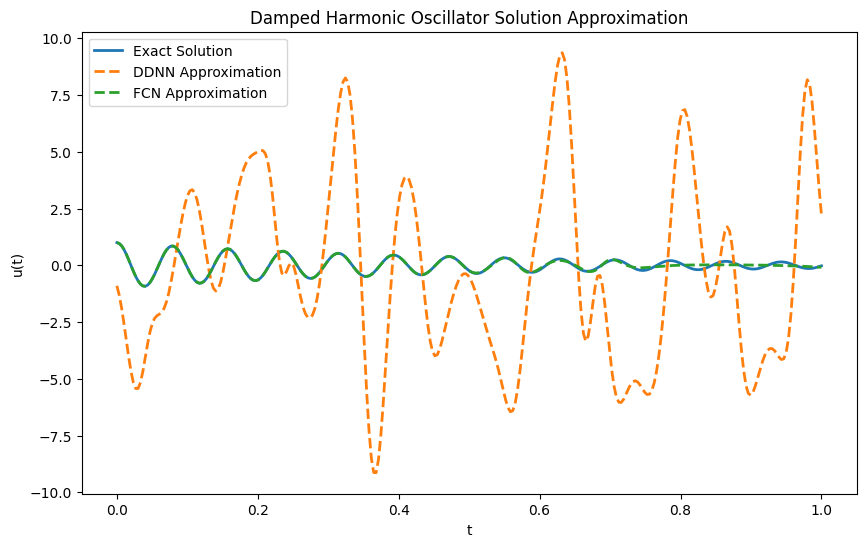

In [27]:
# Evaluate the model
u_pred = jax.vmap(forward,in_axes=(0, None))(x_train,params).flatten()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, label="Exact Solution", linewidth=2)
plt.plot(x_train, u_pred, label="DDNN Approximation", linestyle="--", linewidth=2)
plt.plot(x_train, fcn_u_pred, label="FCN Approximation", linestyle="--", linewidth=2)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Damped Harmonic Oscillator Solution Approximation")
plt.legend()
plt.show()

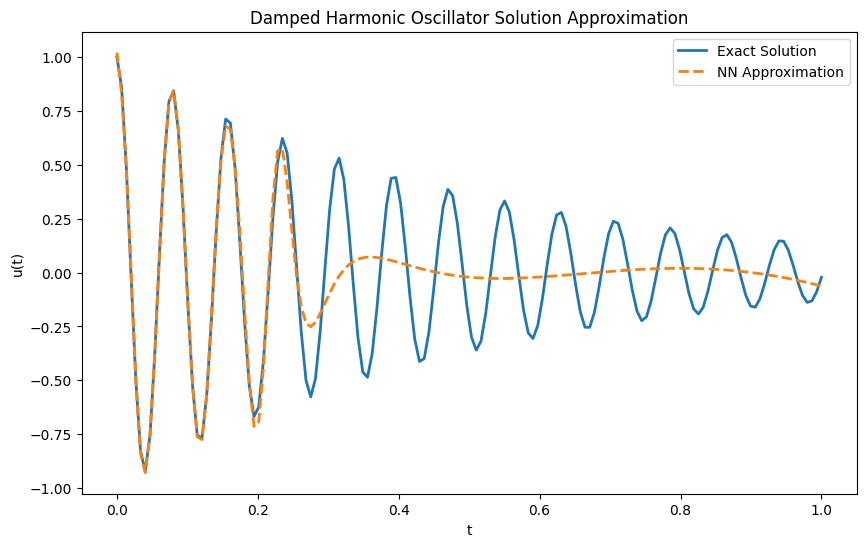

In [116]:
# Evaluate the model
u_pred = jax.vmap(forward,in_axes=(0, None))(x_train,params).flatten()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, label="Exact Solution", linewidth=2)
plt.plot(x_train, u_pred, label="NN Approximation", linestyle="--", linewidth=2)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Damped Harmonic Oscillator Solution Approximation")
plt.legend()
plt.show()

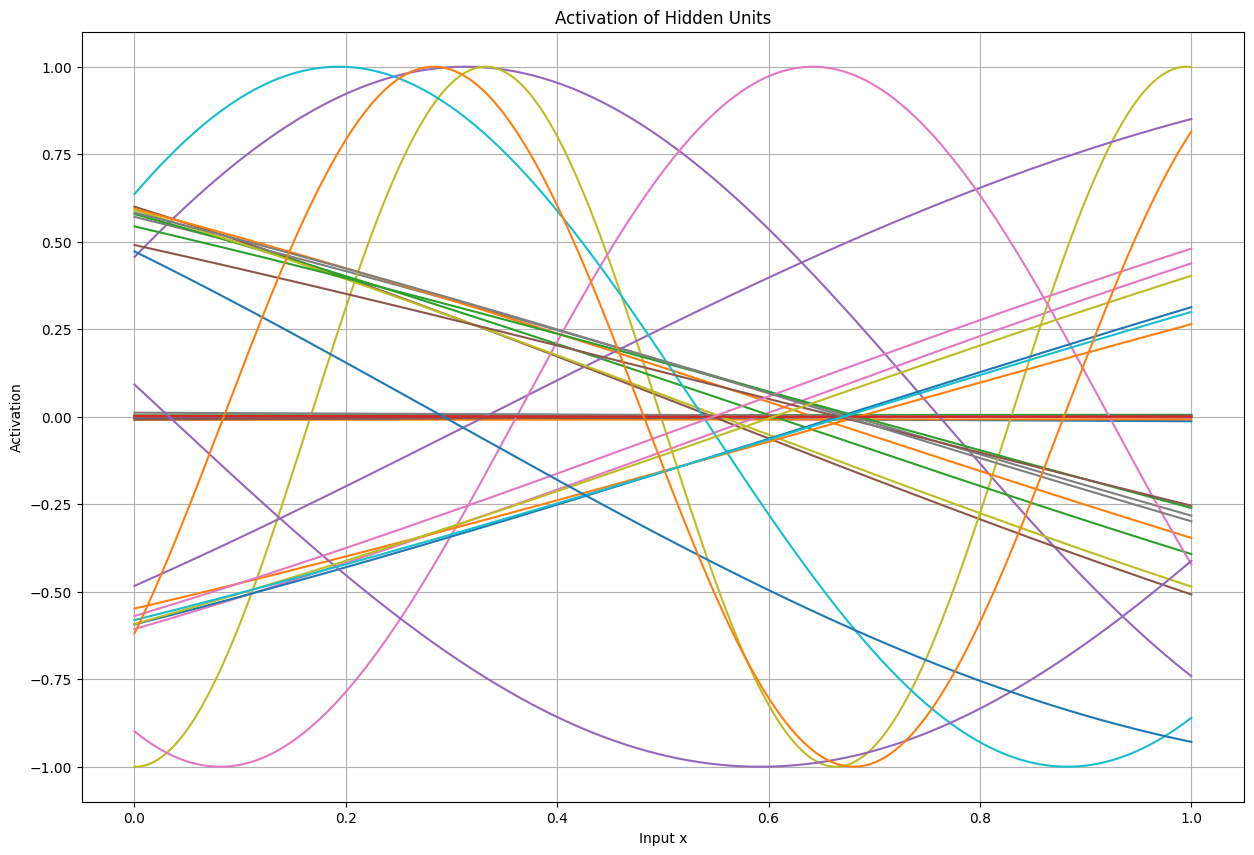

In [155]:
x_vals = jnp.linspace(0, 1, 500).reshape(-1, 1)
sigma = jnp.sin
hidden_activations = get_hidden_activations(x_vals, params,sigma)

plt.figure(figsize=(15, 10))
for i, activation in enumerate(hidden_activations):
    plt.plot(x_vals, activation, label=f'Hidden Unit {i+1}')
    
plt.xlabel('Input x')
plt.ylabel('Activation')
plt.title('Activation of Hidden Units')

plt.grid()
plt.show()

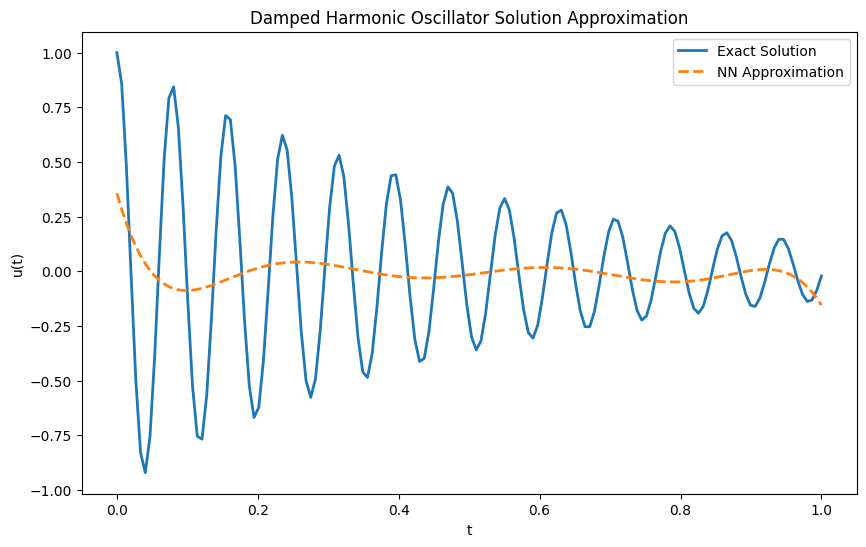

In [12]:
# Evaluate the model
u_pred = jax.vmap(forward,in_axes=(0, None))(x_train,params).flatten()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, label="Exact Solution", linewidth=2)
plt.plot(x_train, u_pred, label="NN Approximation", linestyle="--", linewidth=2)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Damped Harmonic Oscillator Solution Approximation")
plt.legend()
plt.show()

# # #plot the loss
# # plt.figure(figsize=(10, 6))
# # plt.plot(range(epochs),jnp.log10(jnp.array(loss_values)))
# # plt.xlabel("Epoch")
# # plt.ylabel("Loss")
# plt.title("Training Loss")

Creating M_ode...
M_ode created in 1.69 seconds.
exact_solution scaled.
Creating B_train...
B_train created in 0.65 seconds.
B_train scaled
Time taken for solver: 0.0080 seconds
a calculated in 0.32 seconds.
Creating M_sol...
M_sol created in 0.32 seconds.
Loss Value: 9.54e-03
Test Loss Value: 9.54e-03


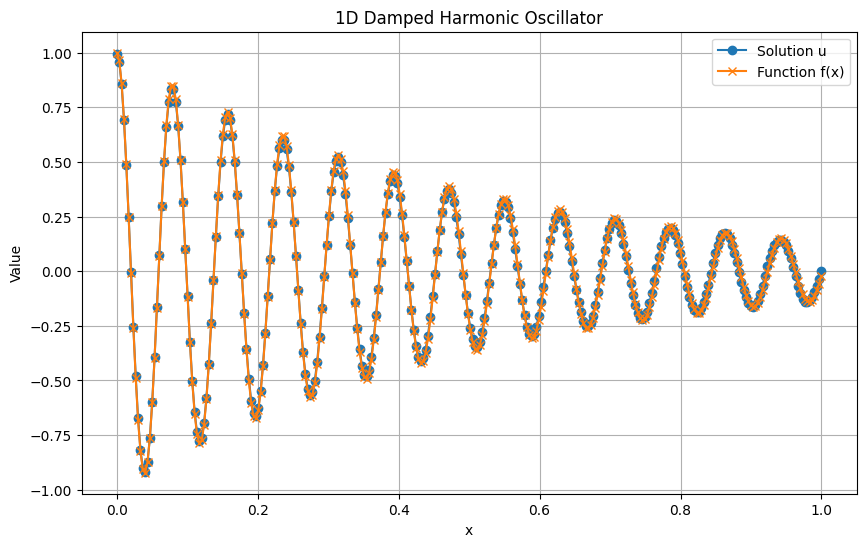

Condition number of M_ode_scaled: 1.69e+09
Condition number of M_sol: 2.99e+09
Condition Number of LHS: 1.07e+12
Total time taken: 2.39 seconds.


In [141]:
RHS_func = zero_RHS
u_func = harm_u_exact
n_train = 150
n_test = 300
J=20
C=32
R=25
width = 1.9
sigma = jnp.sin
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"
results = elmfbpinn(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigma,
    title,
    weights=None,
    biases=None,
    lmda=1,
    plot_window=False,
)

In [190]:

# Extract all weights except the last layer
all_weights_except_last = [param[0] for param in params[:-1]]

# Extract all biases except the last layer
all_biases_except_last = [param[1] for param in params[:-1]]

In [192]:
all_weights_except_last

[Array([[ 6.7891783e-01, -1.6516003e+01, -1.1093980e+00, -2.3607881e-04,
          2.6709845e+00, -1.0003926e+00,  3.7095211e+00,  1.0047066e+00,
          4.0488820e+00,  6.0976324e+00, -5.9187639e-01, -9.5632696e-01,
         -1.3369852e+00, -1.9403299e+00,  4.8124450e-01,  3.1663475e+01,
          4.5774794e-01,  1.0181203e+01, -1.2345327e+01,  3.4567368e+00,
         -4.9392390e-01,  2.0788753e+00,  5.2010059e-01,  2.0355954e+00,
         -1.2591560e+00, -1.2404857e+00, -2.4015484e+00, -1.1395837e+00,
          8.3571517e-01, -1.5497224e+00, -1.1324297e+00,  1.3474784e+01]],      dtype=float32),
 Array([[ 0.03760881, -0.2678805 , -0.09228618, ...,  0.40228388,
         -0.40601885,  0.9991075 ],
        [-3.0531929 ,  0.42966637, -3.5447693 , ...,  0.15799591,
         -0.6827625 , -1.2483149 ],
        [-1.085938  ,  0.54682493, -0.8211338 , ..., -0.38581562,
          0.21786201, -0.67661464],
        ...,
        [-0.17463867,  0.07389243, -0.39207226, ..., -0.10888233,
        

In [194]:
RHS_func = zero_RHS
u_func = harm_u_exact
n_train = 150
n_test = 300
J=20
C=32
R=25
width = 1.9
sigma = jnp.sin
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"
results = elmfbpinn(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigma,
    title,
    all_weights_except_last,
    all_biases_except_last,
    lmda=1,
    plot_window=False,
)

Creating M_ode...


TracerIntegerConversionError: The __index__() method was called on traced array with shape int32[]
This BatchTracer with object id 140020814246784 was created on line:
  /home/ophunix/ELM-FBPINN/elmfbpinns/example/../matrix_builder.py:56 (single_M_entry)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerIntegerConversionError